In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math


In [2]:
data = pd.read_csv('./Assets/data.csv', index_col = 'Date')
data = data.iloc[:2665, :]
data

,High,Low,Open,Close,Volume,Adj Close,pct_change,log_change,7ma,14ma,...,investment_dif,foreign_buy,foreign_sell,foreign_dif,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2010/2/10,52.250000,51.700001,51.950001,52.099998,11219,52.099998,0.010669,0.010613,51.943241,52.708595,...,1454164689,1.551380e+10,2.549564e+10,-9981838210,96.358920,98.341083,94.157682,97.504515,95.290389,94.816094
2010/2/22,53.150002,52.599998,53.049999,52.599998,11187,52.599998,0.009597,0.009551,52.107470,52.693884,...,771651699,2.846749e+10,2.503619e+10,3431302085,96.242195,98.002049,93.597325,95.929373,90.414471,88.712660
2010/2/23,52.750000,52.200001,52.599998,52.599998,9571,52.599998,0.000000,0.000000,52.230624,52.681192,...,-387699136,2.422218e+10,2.360860e+10,613580581,96.125140,97.662731,93.037830,94.352361,85.604138,82.741271
2010/2/24,52.549999,52.150002,52.150002,52.250000,11026,52.250000,-0.006654,-0.006676,52.235469,52.623011,...,483080557,2.027639e+10,2.546846e+10,-5192069643,96.007757,97.323153,92.479275,92.775246,80.907607,76.994296
2010/2/25,52.299999,51.349998,52.250000,51.650002,20361,51.650002,-0.011483,-0.011550,52.089087,52.491931,...,-484640740,2.259238e+10,3.143820e+10,-8845826819,95.890048,96.983341,91.921743,91.199799,76.371194,71.557895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/12/25,119.599998,118.599998,119.099998,118.949997,2801317,118.949997,0.001263,0.001262,118.587579,118.090677,...,373419980,2.930742e+10,2.403325e+10,5274170949,111.049753,127.320992,121.886350,124.377775,120.608542,121.100219
2020/12/28,120.000000,119.050003,119.050003,120.000000,3407442,120.000000,0.008827,0.008789,118.940684,118.345254,...,139024268,5.145881e+10,3.850894e+10,12949871214,111.054398,127.489588,122.247031,124.754413,121.300176,121.903124
2020/12/29,120.199997,119.349998,120.050003,119.900002,3093979,119.900002,-0.000833,-0.000834,119.180513,118.552554,...,-767399344,4.903891e+10,5.029541e+10,-1256508512,111.058523,127.656402,122.607526,125.124296,122.062133,122.757176


In [3]:
data['y'] = data['Close']

x = data.iloc[:, :59].values
y = data.iloc[:, 59].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2132, 59) trainY: (2132,)
testX: (533, 59) testY: (533,)


In [4]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [5]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([59, 400, 400, 400, 10], 10)

[1/300] Loss: 481.5333881378174
[2/300] Loss: 444.09318351745605
[3/300] Loss: 424.61256980895996
[4/300] Loss: 417.1307067871094
[5/300] Loss: 417.41621589660645
[6/300] Loss: 411.6128234863281
[7/300] Loss: 395.15754890441895
[8/300] Loss: 385.92315196990967
[9/300] Loss: 387.6674470901489
[10/300] Loss: 389.90044021606445
[11/300] Loss: 386.2342309951782
[12/300] Loss: 376.4832229614258
[13/300] Loss: 364.7318067550659
[14/300] Loss: 357.53318786621094
[15/300] Loss: 360.22611236572266
[16/300] Loss: 366.24914360046387
[17/300] Loss: 359.1361322402954
[18/300] Loss: 343.4504737854004
[19/300] Loss: 335.8218717575073
[20/300] Loss: 336.90217208862305
[21/300] Loss: 340.2455406188965
[22/300] Loss: 341.7657537460327
[23/300] Loss: 340.02390480041504
[24/300] Loss: 334.88854217529297
[25/300] Loss: 326.72052478790283
[26/300] Loss: 316.35967922210693
[27/300] Loss: 305.5020523071289
[28/300] Loss: 296.92971897125244
[29/300] Loss: 293.9537401199341
[30/300] Loss: 298.2527770996094
[31/

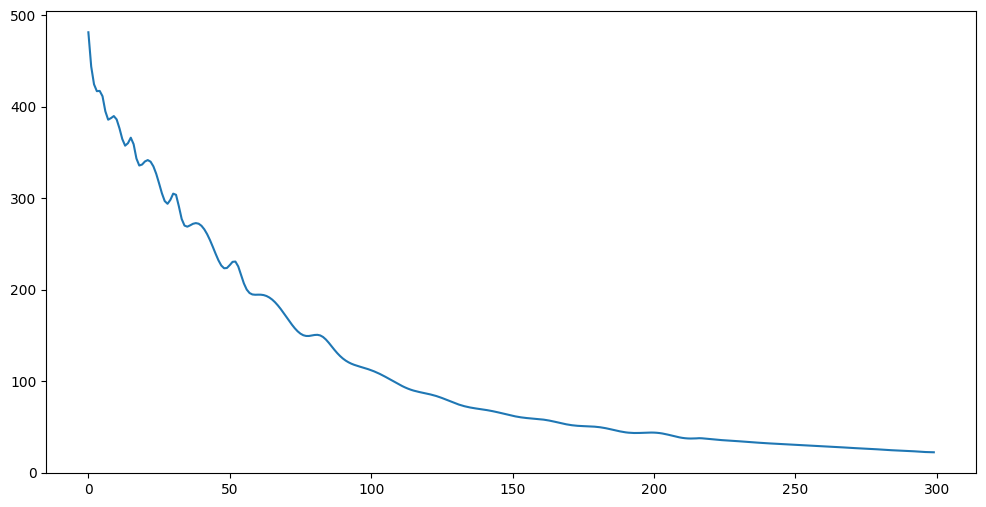

In [6]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [7]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [8]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [9]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [10]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2129, 3, 69]) train_y: torch.Size([2129, 1]) train_y_gan: torch.Size([2129, 4, 1])
test_x: torch.Size([530, 3, 69]) test_y: torch.Size([530, 1]) test_y_gan: torch.Size([530, 4, 1])


In [11]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [12]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(69).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/165] LossD: 23.569106817245483 LossG:11.664989709854126
[2/165] LossD: 23.565280437469482 LossG:11.783096075057983
[3/165] LossD: 23.566854238510132 LossG:11.794115900993347
[4/165] LossD: 23.56710958480835 LossG:11.783741891384125
[5/165] LossD: 23.56684899330139 LossG:11.783199846744537
[6/165] LossD: 23.566652297973633 LossG:11.784184634685516
[7/165] LossD: 23.566493034362793 LossG:11.78476470708847
[8/165] LossD: 23.56639325618744 LossG:11.784365832805634
[9/165] LossD: 23.56619119644165 LossG:11.784785509109497
[10/165] LossD: 23.565959453582764 LossG:11.785147190093994
[11/165] LossD: 23.5656875371933 LossG:11.785595118999481
[12/165] LossD: 23.5654319524765 LossG:11.785156428813934
[13/165] LossD: 23.56508767604828 LossG:11.785199463367462
[14/165] LossD: 23.5647931098938 LossG:11.785117208957672
[15/165] LossD: 23.564406514167786 LossG:11.783948838710785
[16/165] LossD: 23.563892722129822 LossG:11.784873485565186
[17/165] LossD: 23.56330633163452 LossG:11.78643548488617
[18

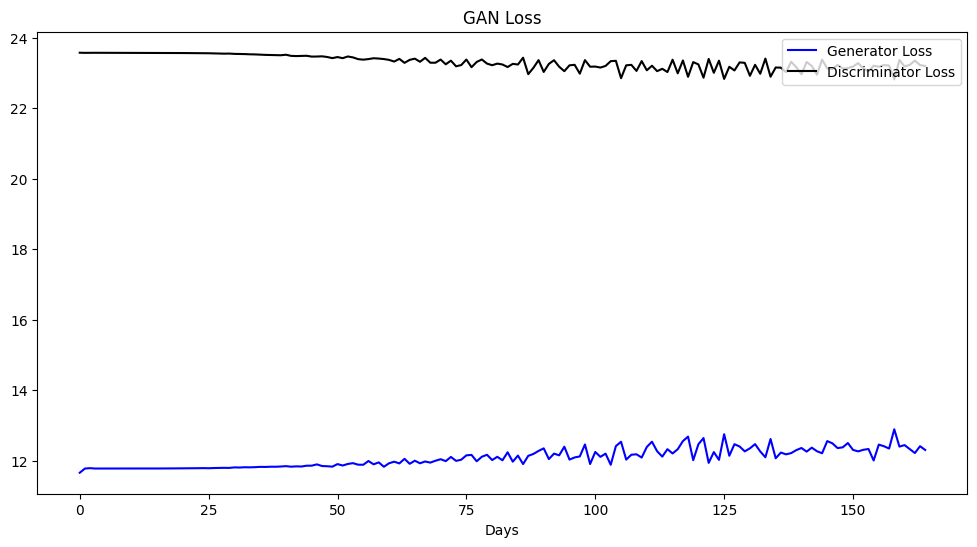

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [14]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:7.879012134676241


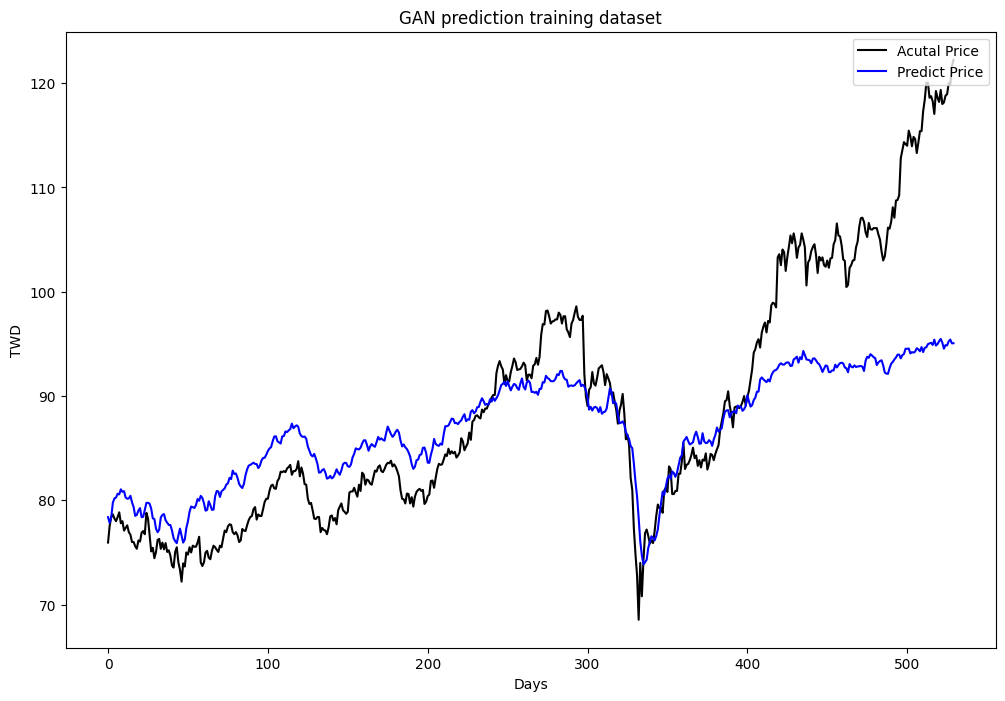

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

## LSTM hybrid Model 

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


input_size = train_x_slide.shape[-1]  # This should match the number of features per time step
sequence_length = train_x_slide.shape[1]  # Number of time steps in each sequence
output_size = 1  # Predicting a single value (next day's price)

class LSTMStockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMStockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = hn[-1]
        out = self.fc(out)
        return out

# Model instantiation
hidden_size = 50  
num_layers = 2
model = LSTMStockPredictor(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_dataset = TensorDataset(train_x_slide, train_y_slide)
test_dataset = TensorDataset(test_x_slide, test_y_slide)

# Create DataLoaders
batch_size = 64  
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Training Parameters
num_epochs = 50  # Number of epochs to train for

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Logging
    if (epoch+1) % 5 == 0:  # Log every 5 epochs
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

# Evaluate the model
model.eval()  # Set model to evaluation mode
test_loss = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(test_loader)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([17, 1])) that is different to the input size (torch.Size([17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5, Loss: 0.06474341912304654
Epoch 10, Loss: 0.064931470900774
Epoch 15, Loss: 0.06494478530743543
Epoch 20, Loss: 0.06473223722594626
Epoch 25, Loss: 0.06460006173480959
Epoch 30, Loss: 0.06501275958383784
Epoch 35, Loss: 0.06463014170089189
Epoch 40, Loss: 0.06440799518981401
Epoch 45, Loss: 0.06415162443676416
Epoch 50, Loss: 0.0644640738473219
Test Loss: 0.5148178388675054


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Hyperparamter tuning for LSTM

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# LSTM Model Definition
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMStockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = hn[-1]
        out = self.fc(out)
        return out


# Hyperparameter Ranges
learning_rates = [0.001, 0.005, 0.01]
hidden_sizes = [32, 64, 128]
num_layers_options = [1, 2, 3]

best_test_loss = float('inf')
best_params = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for num_layers in num_layers_options:
            print(f"Training with lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}")

            # Create model with current hyperparameters
            model = LSTMStockPredictor(input_size=train_x_slide.shape[-1],
                                       hidden_size=hidden_size,
                                       num_layers=num_layers,
                                       output_size=1)
            model.to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # DataLoaders
            train_loader = DataLoader(dataset=TensorDataset(train_x_slide, train_y_slide),
                                      batch_size=64, shuffle=True)
            test_loader = DataLoader(dataset=TensorDataset(test_x_slide, test_y_slide),
                                     batch_size=64, shuffle=False)

            # Training Loop
            for epoch in range(10):  # Use a smaller number of epochs for demonstration
                model.train()
                for x_batch, y_batch in train_loader:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    y_pred = model(x_batch)
                    loss = criterion(y_pred.squeeze(), y_batch)
                    loss.backward()
                    optimizer.step()

            # Evaluation
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    y_pred = model(x_batch)
                    test_loss += criterion(y_pred.squeeze(), y_batch).item()
            test_loss /= len(test_loader)

            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_params = {'lr': lr, 'hidden_size': hidden_size, 'num_layers': num_layers}

# Output the best performing set of hyperparameters
print(f"Best Test Loss: {best_test_loss}")
print(f"Best Hyperparameters: {best_params}")


Training with lr=0.001, hidden_size=32, num_layers=1
Training with lr=0.001, hidden_size=32, num_layers=2
Training with lr=0.001, hidden_size=32, num_layers=3
Training with lr=0.001, hidden_size=64, num_layers=1
Training with lr=0.001, hidden_size=64, num_layers=2
Training with lr=0.001, hidden_size=64, num_layers=3
Training with lr=0.001, hidden_size=128, num_layers=1
Training with lr=0.001, hidden_size=128, num_layers=2
Training with lr=0.001, hidden_size=128, num_layers=3
Training with lr=0.005, hidden_size=32, num_layers=1
Training with lr=0.005, hidden_size=32, num_layers=2
Training with lr=0.005, hidden_size=32, num_layers=3
Training with lr=0.005, hidden_size=64, num_layers=1
Training with lr=0.005, hidden_size=64, num_layers=2
Training with lr=0.005, hidden_size=64, num_layers=3
Training with lr=0.005, hidden_size=128, num_layers=1
Training with lr=0.005, hidden_size=128, num_layers=2
Training with lr=0.005, hidden_size=128, num_layers=3
Training with lr=0.01, hidden_size=32, n

## Enhanced LSTM

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

class EnhancedLSTMStockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(EnhancedLSTMStockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

input_size = train_x_slide.shape[-1]  # Adjust according to your dataset
hidden_size = 32  # From tuning
num_layers = 2  # From tuning
output_size = 1  # Predicting a single value
dropout_rate = 0.2  # Example dropout rate; adjust as necessary

model = EnhancedLSTMStockPredictor(input_size, hidden_size, num_layers, output_size, dropout_rate)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)  # From tuning

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 100  # Or another value based on your needs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    scheduler.step()  # Adjust the learning rate
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')



Epoch 5, Loss: 0.0656969691900646
Epoch 10, Loss: 0.06553762482807916
Epoch 15, Loss: 0.0646309528280707
Epoch 20, Loss: 0.0642471898566274
Epoch 25, Loss: 0.06417621398235068
Epoch 30, Loss: 0.06410601658417898
Epoch 35, Loss: 0.0650949478149414
Epoch 40, Loss: 0.06412287396104897
Epoch 45, Loss: 0.06453670254525017
Epoch 50, Loss: 0.06387310113538713
Epoch 55, Loss: 0.06522997874109183
Epoch 60, Loss: 0.06386625920148457
Epoch 65, Loss: 0.06406246049000937
Epoch 70, Loss: 0.06460556223550264
Epoch 75, Loss: 0.06407866309232571
Epoch 80, Loss: 0.06432718728833339
Epoch 85, Loss: 0.06417568477199358
Epoch 90, Loss: 0.06407026990371592
Epoch 95, Loss: 0.06370385889621343
Epoch 100, Loss: 0.06412385699941832


Training dataset RMSE: 0.2502844503547938


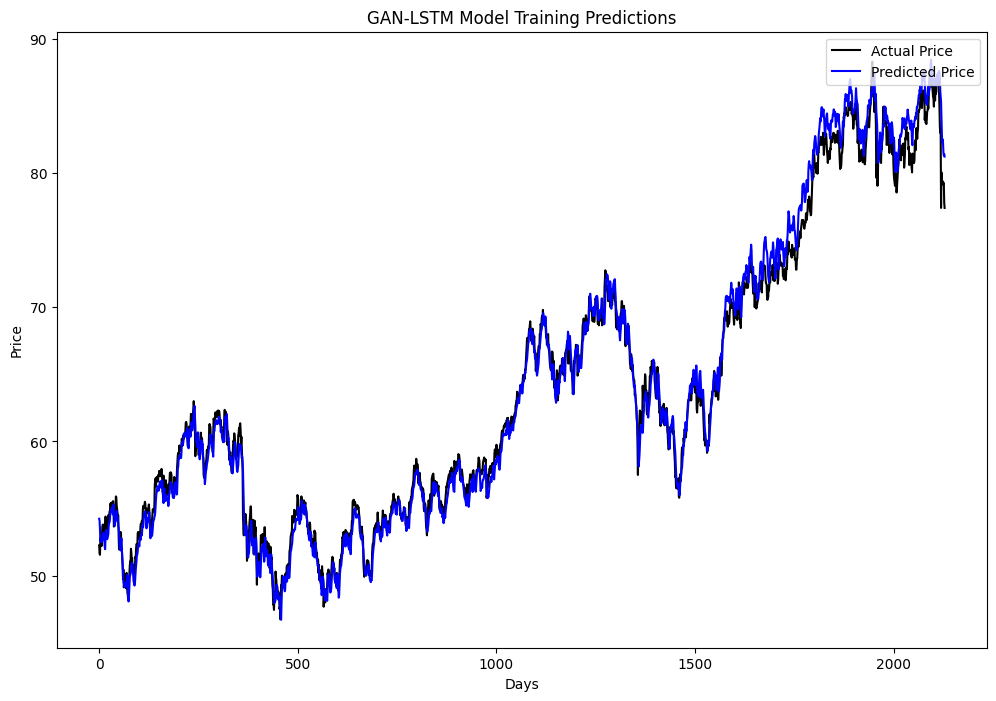

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt


model.eval()

# Store predictions and actual values
all_predictions = []
all_actuals = []

with torch.no_grad():
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass to get the model's predictions
        predictions = model(x_batch)
        
        # Move predictions and actual values to CPU, convert them to numpy arrays if necessary
        all_predictions.extend(predictions.cpu().numpy())
        all_actuals.extend(y_batch.cpu().numpy())

# Flatten the lists if they are nested and convert to numpy arrays for calculation
all_predictions = np.array(all_predictions).flatten()
all_actuals = np.array(all_actuals).flatten()

# Calculate RMSE
rmse = sqrt(mean_squared_error(all_actuals, all_predictions))
print(f'Training dataset RMSE: {rmse}')
rmse = sqrt(mean_squared_error(y_train_true, y_train_pred))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color='black', label='Actual Price')
plt.plot(y_train_pred, color='blue', label='Predicted Price')
plt.title('GAN-LSTM Model Training Predictions')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc='upper right')
plt.show()



## Testing Results


In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Ensure the model is in evaluation mode
model.eval()

# Store predictions and actual values for the test dataset
test_predictions = []
test_actuals = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:  # Use test_loader here
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass to get the model's predictions
        predictions = model(x_batch)
        
        # Move predictions and actual values to CPU, convert them to numpy arrays if necessary
        test_predictions.extend(predictions.cpu().numpy())
        test_actuals.extend(y_batch.cpu().numpy())

# Flatten the lists if they are nested and convert to numpy arrays for calculation
test_predictions = np.array(test_predictions).flatten()
test_actuals = np.array(test_actuals).flatten()

# If your target variable was scaled or normalized, apply the inverse transformation
test_predictions = y_scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
test_actuals = y_scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()

# Calculate RMSE for the test dataset
test_rmse = sqrt(mean_squared_error(test_actuals, test_predictions))
print(f'Test dataset RMSE: {test_rmse}')





Test dataset RMSE: 27.618793049157443


Testing dataset RMSE:7.879012134676241


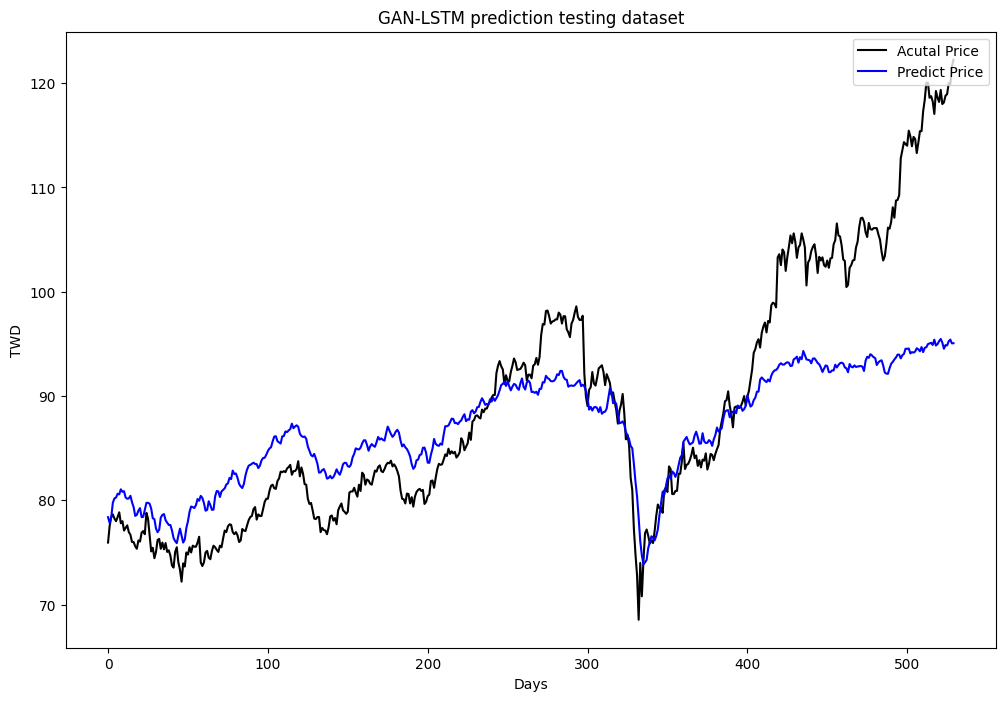

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN-LSTM prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')